# Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
# Numpy cries because it is an old code so we monkey patch it
np.int = int
np.bool = bool
np.float = float

# Import the Dataset

In [2]:
URM_all_dataframe = pd.read_csv('data_train.csv', 
                                sep=",", 
                                header= 0, 
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

### Building the sparse COO matrix using URM

In [3]:
import scipy.sparse as sps
# Build the COO sparse matrix associated with the URM
URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values))) ## .values --> numpy array, df[..] --> pd series

### Split the data in train and validation set

In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2976 (22.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2577 (19.8%) Users that have less than 1 test interactions


# Implement UserBasedCF

In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [100, 200, 500, 600, 800, 1000]
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 1255.31 column/sec. Elapsed time 10.38 sec
EvaluatorHoldout: Processed 10049 (100.0%) in 9.40 sec. Users per second: 1069
UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 1295.82 column/sec. Elapsed time 10.05 sec
EvaluatorHoldout: Processed 10049 (100.0%) in 8.15 sec. Users per second: 1234
UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 1098.51 column/sec

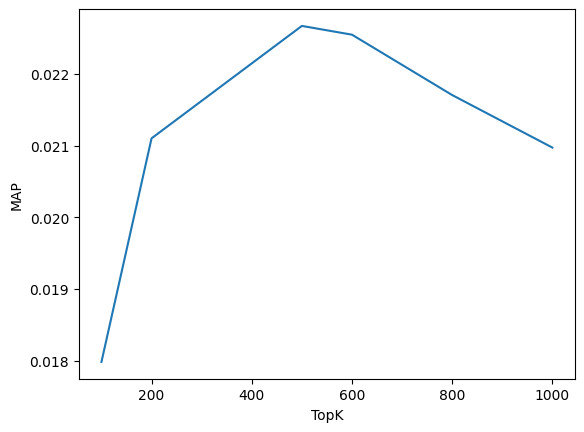

In [8]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [10]:
# The value of k where MAP is the highest is 500
best_k = 500

In [13]:
# Let's find the optimal shrinkage
x_tick = [0,0.5,1,2]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=best_k)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 777.39 column/sec. Elapsed time 16.75 sec
EvaluatorHoldout: Processed 10049 (100.0%) in 10.05 sec. Users per second: 1000
UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 1117.51 column/sec. Elapsed time 11.66 sec
EvaluatorHoldout: Processed 10049 (100.0%) in 9.79 sec. Users per second: 1026
UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 1080.50 column/sec

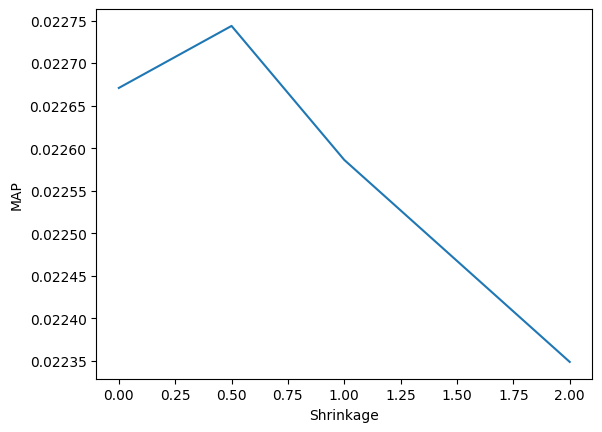

In [14]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [15]:
best_shrinkage = 0.5

In [16]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=best_shrinkage, topK=best_k)

UserKNNCFRecommender: URM Detected 845 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13025 (100.0%), 705.86 column/sec. Elapsed time 18.45 sec


In [20]:
def write_predictions(recommender_object, at=10):
    prediction_df = pd.read_csv('data_target_users_test.csv', sep= ",",
                                header=0, 
                                dtype={0:int},
                                engine='python')
    #prediction_df['mapped user'] = prediction_df['user_id'].map(user_original_ID_to_index).fillna(-1).astype(int)
    #prediction_df['item_list'] = prediction_df['mapped user'].apply(recommender_object.recommend)
    prediction_df['item_list'] = prediction_df['user_id'].apply(lambda user_id: recommender_object.recommend(user_id)[:at])
    #def map_items(item_list):
    #    return [index_to_item_original.get(item, item) for item in item_list]

    #prediction_df['item_list'] = prediction_df['item_list'].apply(map_items)
    def transform_items_to_string(item_list):
        return ' '.join(map(str, item_list))

    prediction_df['item_list'] = prediction_df['item_list'].apply(transform_items_to_string)
    print(prediction_df.head(10))
    #del prediction_df['mapped user']
    prediction_df.to_csv('submission.csv',index=False)

write_predictions(recommender)

   user_id                                          item_list
0        1                36 101 15 66 506 354 342 183 83 592
1        2                             3 2 8 4 15 5 6 17 19 9
2        3                       59 9 7 259 1 584 536 648 5 4
3        4                         28 27 50 1 37 6 7 5 14 136
4        5                      4 51 88 341 6 26 87 16 36 177
5        6                            8 2 1 7 6 81 14 88 26 3
6        8                        210 20 80 9 11 8 578 2 1 22
7        9  11175 3727 3726 3725 3724 3723 3722 3721 3720 ...
8       10                  3 2 1668 1411 89 809 8 1446 68 11
9       11                           4 1 67 2 44 40 6 3 31 39
